# Running Through Uncertainty: $\text{A Global Analysis of Training Patterns Before and During COVID-19}$
## By Julia Hinds
April 29, 2025

---
<img src="https://upload.wikimedia.org/wikipedia/commons/a/a5/Marat%C3%B3n_Medell%C3%ADn_2019.jpg" width=600px>


## Introduction
This notebook explores running activity data collected from over 36,000 athletes worldwide during 2019 and 2020. The dataset contains detailed information about each run, including distance, duration, date, athlete demographics, and country, and is combined with government COVID-19 stringency index data to assess how the pandemic affected training behaviors.

As a runner myself, I experienced firsthand the disruptions to training routines and race schedules that 2020 brought. Running remained a vital outlet during a challenging year, inspiring me to investigate how athletes around the world adapted their training in response to these unprecedented circumstances.

Key questions about how running habits evolved over time and how they were influenced by lockdowns and major marathons are explored in this analysis. Using Python libraries such as Pandas, Matplotlib, and Seaborn, we visualize trends, compare training loads, and examine how external events shaped running performance during this period.

### Public dataset 
https://www.kaggle.com/datasets/mexwell/long-distance-running-dataset

Above dataset also includes information originally from the Oxford COVID-19 Government Response Tracker$^{2,3}$ (OxCGRT).

### Quick Facts:
- Marathon distance = 26.2 miles (42.195 km)
- World Majors = Abbott World Marathon Majors (AbbottWMM); a series consisting of the largest and most renowned marathons in the world: Tokyo (JPN), Boston (USA), London (GBR), Berlin (DEU), Chicago (USA), New York City (USA)
    - Sydney (AUS) was added in 2024, and thus is not included in this dataset
- Ultramarathon = any race distance longer than a traditional marathon

### Settings for the Notebook
First, we'll want to import relevent libraries and load the all the data (originally stored in CSV files). It is assumed that the data has been locally downloaded.

In [1]:
# Import relevent libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
from datetime import datetime, timedelta

In [2]:
# Create settings for plots
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")

In [3]:
# Load data
# Note, this assumes that you have locally downloaded the relevent 
#   data from Kaggle and put it inside an input/ directory
data_2019_d = pd.read_csv('input/run_ww_2019_d.csv')
data_2020_d = pd.read_csv('input/run_ww_2020_d.csv')

In [4]:
# Concatenate 2019 and 2020 datasets, so now we can just call "data"
data = pd.concat([data_2019_d, data_2020_d], ignore_index=True)

# Re-name columns and add a "miles" distance column for clarity
data.rename(columns={'distance': 'distance_km'}, inplace=True) # re-name with "km" for clarity
data_2019_d.rename(columns={'distance': 'distance_km'}, inplace=True) # re-name with "km" for clarity
data_2020_d.rename(columns={'distance': 'distance_km'}, inplace=True) # re-name with "km" for clarity
data['distance_mi'] = data["distance_km"]*0.621371 # convert km to miles
data_2019_d['distance_mi'] = data_2019_d["distance_km"]*0.621371 # convert km to miles
data_2020_d['distance_mi'] = data_2020_d["distance_km"]*0.621371 # convert km to miles

data.head() # quick peak at the combined data

,Unnamed: 0,datetime,athlete,distance_km,duration,gender,age_group,country,major,distance_mi
0,0,2019-01-01,0,0.00,0.00,F,18 - 34,United States,CHICAGO 2019,0.000000
1,1,2019-01-01,1,5.27,30.20,M,35 - 54,Germany,BERLIN 2016,3.274625
2,2,2019-01-01,2,0.00,0.00,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019",0.000000
3,3,2019-01-01,3,10.50,43.95,M,18 - 34,United Kingdom,LONDON 2017,6.524395
4,4,2019-01-01,4,9.66,48.65,M,35 - 54,United States,BOSTON 2017,6.002444


In [5]:
# Load COVID Stringency Index data
stringency = pd.read_csv('input/covid-stringency-index.csv')  # again, assumes it lives inside the input/ directory
stringency.rename(columns={'Entity': 'country'}, inplace=True) # re-name "entity" to "country" for clarity
stringency.head() # quick peak inside

,country,Code,Date,stringency_index
0,Afghanistan,AFG,2020-01-01,0.0
1,Afghanistan,AFG,2020-01-02,0.0
2,Afghanistan,AFG,2020-01-03,0.0
3,Afghanistan,AFG,2020-01-04,0.0
4,Afghanistan,AFG,2020-01-05,0.0


## Preprocessing

After the data has been loaded, the preprocessing step ensures the datasets are properly formatted for analysis. 

The two years of running activity files are combined into a single dataset. For the COVID-19 stringency index data, the country names are standardized and a datetime column from year, month, and day information is constructed if necessary. Both datasets have their date fields converted to consistent datetime formats to enable accurate merging later. Additionally, we extract the year and month from each run's date to simplify time-based grouping in the subsequent analyses.

In [6]:
# Fix stringency index columns
if 'Entity' in stringency.columns:
    stringency.rename(columns={'Entity': 'country'}, inplace=True)
if 'Day' in stringency.columns and 'Month' in stringency.columns and 'Year' in stringency.columns:
    stringency['date'] = pd.to_datetime(dict(year=stringency['Year'], month=stringency['Month'], day=stringency['Day']))
else:
    # fallback if 'date' exists under a different name
    if 'Date' in stringency.columns:
        stringency.rename(columns={'Date': 'date'}, inplace=True)
    stringency['date'] = pd.to_datetime(stringency['date'])

stringency['country'] = stringency['country'].astype(str)
data['country'] = data['country'].astype(str)
data_2019_d['country'] = data['country'].astype(str)

# Process running activity data
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month

data_2019_d['datetime'] = pd.to_datetime(data_2019_d['datetime'])
data_2019_d['year'] = data_2019_d['datetime'].dt.year
data_2019_d['month'] = data_2019_d['datetime'].dt.month

data_2020_d['datetime'] = pd.to_datetime(data_2020_d['datetime'])
data_2020_d['year'] = data_2020_d['datetime'].dt.year
data_2020_d['month'] = data_2020_d['datetime'].dt.month

## Understanding the Dataset

In this section, we begin to explore the running activity data to understand basic patterns and behaviors. First, we calculate the average running distance and duration per month to observe trends over time, such as seasonal effects or the impact of global events. Next, we identify which months had the highest overall training volume, giving insight into peak periods of athletic activity. We then examine the distributions of individual running distances and durations to characterize typical training efforts across all athletes. Finally, we analyze average running behaviors by gender, highlighting potential differences in training habits. This exploratory analysis establishes a baseline understanding of the data before investigating more complex effects such as the influence of COVID-19 restrictions.

Investigating how the $\textbf{average distance and duration of runs change over time}$:

In [7]:
# only want to consider entries with distances greater than zero, otherwise including 0.0 distances 
#  will skew results low

distance_mask = data['distance_mi']>0
distance_greater_than_zero = data[distance_mask]

distance_mask_2019 = data_2019_d['distance_mi']>0
distance_greater_than_zero_2019 = data_2019_d[distance_mask_2019]

distance_mask_2020 = data_2020_d['distance_mi']>0
distance_greater_than_zero_2020 = data_2020_d[distance_mask_2020]

avg_by_month = distance_greater_than_zero.groupby(['year', 'month'])[['distance_mi', 'duration']].mean().reset_index()
avg_by_month.head() 

,year,month,distance_mi,duration
0,2019,1,7.185198,62.609557
1,2019,2,7.680522,66.561743
2,2019,3,8.095104,70.063438
3,2019,4,7.400289,65.033020
4,2019,5,6.876421,61.280033


In [8]:
avg_by_month_2019 = distance_greater_than_zero_2019.groupby(['year', 'month'])[['distance_mi', 'duration']].mean().reset_index()
avg_by_month_2020 = distance_greater_than_zero_2020.groupby(['year', 'month'])[['distance_mi', 'duration']].mean().reset_index()
month_names = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

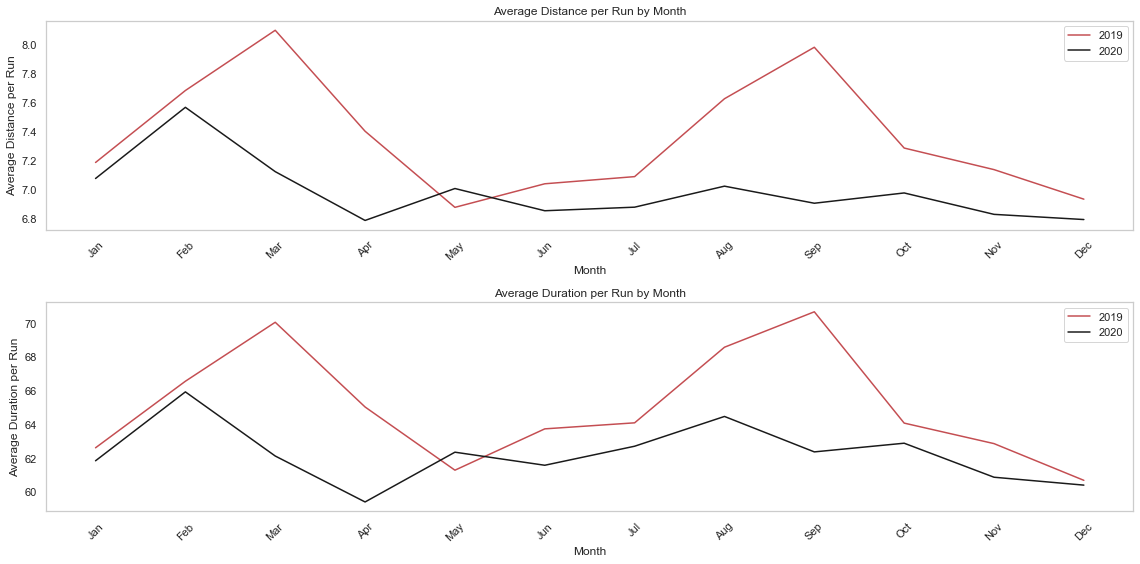

In [9]:
figure, (ax1,ax2) = plt.subplots(2,1, figsize=[16,8])

ax1.plot(avg_by_month_2019['month'] + (avg_by_month_2019['year']-2019)*12, avg_by_month_2019['distance_mi'],"r-", label='2019')
ax1.plot(avg_by_month_2020['month'] + (avg_by_month_2020['year']-2020)*12, avg_by_month_2020['distance_mi'],"k-", label='2020')
ax1.title.set_text('Average Distance per Run by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Distance per Run')
month_numbers = avg_by_month_2019['month'].unique()
month_names = [calendar.month_abbr[m] for m in month_numbers]
ax1.set_xticks(month_numbers)
ax1.set_xticklabels(month_names, rotation=45)
ax1.legend()

ax2.plot(avg_by_month_2019['month'] + (avg_by_month_2019['year']-2019)*12, avg_by_month_2019['duration'],"r-", label='2019')
ax2.plot(avg_by_month_2020['month'] + (avg_by_month_2020['year']-2020)*12, avg_by_month_2020['duration'],"k-", label='2020')
ax2.title.set_text('Average Duration per Run by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Duration per Run')
month_numbers2 = avg_by_month_2020['month'].unique()
month_names2 = [calendar.month_abbr[m] for m in month_numbers2]
ax2.set_xticks(month_numbers2)
ax2.set_xticklabels(month_names2, rotation=45)
ax2.legend()

ax1.grid()
ax2.grid()

plt.tight_layout()

The overall trends for both the average distance and average duration over time show a $\textit{slight decrease}$ across the two-year period, suggesting a $\textit{gradual reduction}$ in training intensity or volume among athletes. However, this $\textit{decline is not linear}$; there are clear oscillations corresponding to seasonal patterns, with peaks generally occurring during spring and fall months. Although, as expected, the trends between the average distance and average duration is mirrored, with longer distances requiring more time.

Next, investigating which months had the $\textbf{highest total running activity}$:

In [10]:
total_by_month = data.groupby(['year', 'month'])['distance_mi'].sum().reset_index()
total_by_month.head()

,year,month,distance_mi
0,2019,1,2.942001e+06
1,2019,2,2.824750e+06
2,2019,3,3.345885e+06
3,2019,4,2.785750e+06
4,2019,5,2.628141e+06


In [11]:
month_names_full = ["January 2019", "February 2019", "March 2019", "April 2019", "May 2019", "June 2019",
               "July 2019", "August 2019", "September 2019", "October 2019", "November 2019", "December 2019",
              "January 2020", "February 2020", "March 2020", "April 2020", "May 2020", "June 2020",
               "July 2020", "August 2020", "September 2020", "October 2020", "November 2020", "December 2020"]

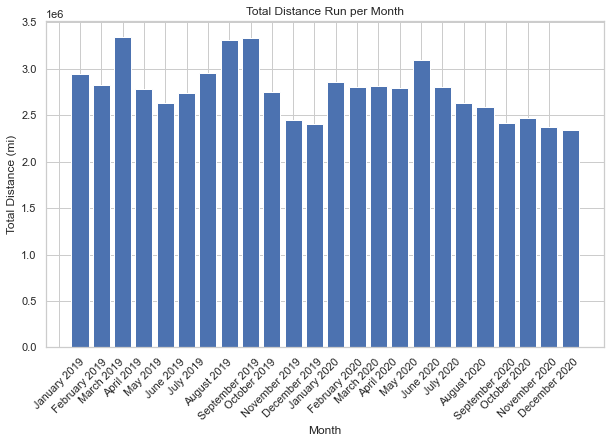

In [12]:
plt.bar(total_by_month['month'] + (total_by_month['year']-2019)*12, total_by_month['distance_mi'])
plt.xlabel('Month')
plt.ylabel('Total Distance (mi)')
plt.xticks((total_by_month['month'] + (total_by_month['year']-2019)*12)-1, month_names_full, rotation=45)
plt.title('Total Distance Run per Month')
plt.show()

As predicted above, the fluctuations most likely influenced by favorable running conditions, race seasons, or training cycles leading up to major events. Most of the World Major Marathons occur in either the spring or fall, which would cause training to increase across the summer and winter months, leading to peaks during spring and fall months. This is reflected in the 2019 period; however the impact of external factors such as the COVID-19 pandemic is likely reflected in the more pronounced drops observed in early to mid-2020, as well as the overall decrease later in 2020 as a lot of races were cancelled, postponed, or moved virtually.

Examining the distribution of $\textbf{running distances and durations across all athletes}$:

In [13]:
# again, only want to consider entries with distances greater than zero
distance_mask = data['distance_mi']>0
distance_greater_than_zero = data[distance_mask]
distance_greater_than_zero.head()

,Unnamed: 0,datetime,athlete,distance_km,duration,gender,age_group,country,major,distance_mi,year,month
1,1,2019-01-01,1,5.27,30.200000,M,35 - 54,Germany,BERLIN 2016,3.274625,2019,1
3,3,2019-01-01,3,10.50,43.950000,M,18 - 34,United Kingdom,LONDON 2017,6.524395,2019,1
4,4,2019-01-01,4,9.66,48.650000,M,35 - 54,United States,BOSTON 2017,6.002444,2019,1
5,5,2019-01-01,5,10.38,50.133333,F,35 - 54,United States,BOSTON 2015,6.449831,2019,1
6,6,2019-01-01,6,10.11,53.183333,M,55 +,United States,BOSTON 2017,6.282061,2019,1


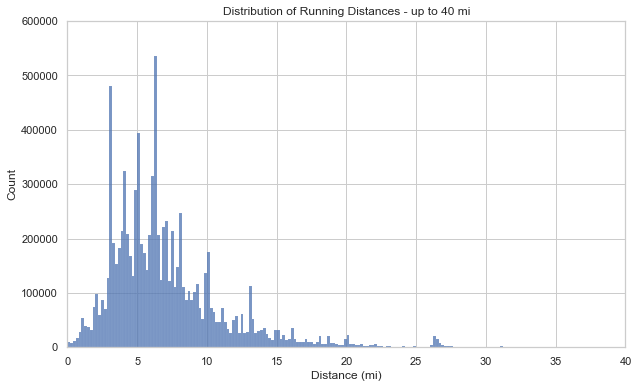

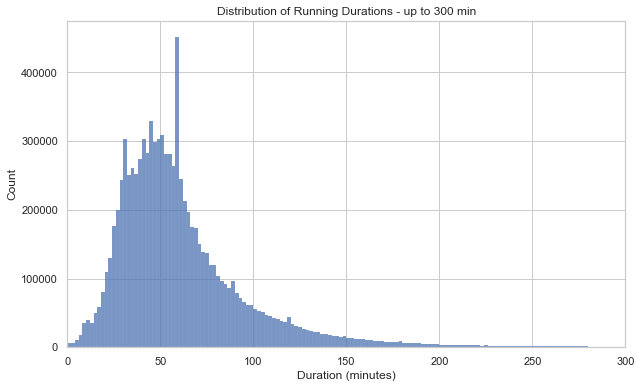

In [14]:
sns.histplot(distance_greater_than_zero['distance_mi'], binwidth=.2)
plt.title('Distribution of Running Distances - up to 40 mi')
plt.xlim(0, 40) # very few entries larger than 40 miles, will address those seperatly next
plt.xlabel('Distance (mi)')
plt.ylim(0,600000)
plt.show()

sns.histplot(distance_greater_than_zero['duration'], binwidth=2)
plt.title('Distribution of Running Durations - up to 300 min')
plt.xlim(0, 300) # very few entries larger than 300 minutes, will address those seperatly next
plt.xlabel('Duration (minutes)')
plt.show()

For most of the dataset, the average run was approximately 6 miles, typically taking around 60 minutes to complete. Interestingly, the data shows noticeable spikes at whole-number distances such as 3, 4, 5, and 6 miles, suggesting that many runners tend to target round mileage goals.
At the upper extreme, a small subset of athletes consistently logged runs exceeding 30 miles, falling into the category of ultramarathons:

In [15]:
great_distance_mask = data['distance_mi']>30
great_distance_greater_than_zero = data[great_distance_mask]
great_distance_greater_than_zero.head()

,Unnamed: 0,datetime,athlete,distance_km,duration,gender,age_group,country,major,distance_mi,year,month
2876,2876,2019-01-01,3001,62.76,412.233333,M,35 - 54,China,TOKYO 2017,38.997244,2019,1
3373,3373,2019-01-01,3508,49.14,241.000000,M,35 - 54,United Kingdom,LONDON 2019,30.534171,2019,1
3923,3923,2019-01-01,4076,61.72,347.000000,M,35 - 54,United States,"BOSTON 2015,NEW YORK 2019",38.351018,2019,1
4972,4972,2019-01-01,5171,57.54,302.000000,M,55 +,United States,BOSTON 2013,35.753687,2019,1
5049,5049,2019-01-01,5252,60.00,325.000000,M,35 - 54,France,BOSTON 2019,37.282260,2019,1


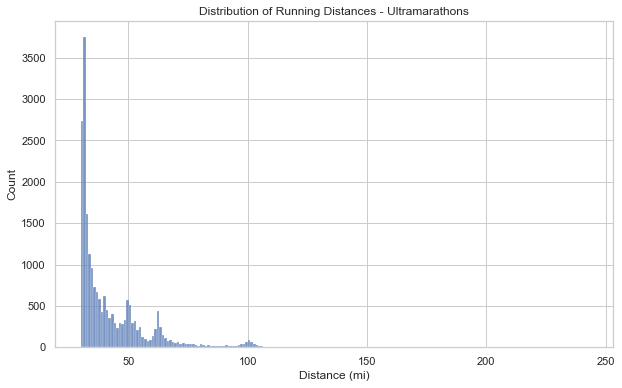

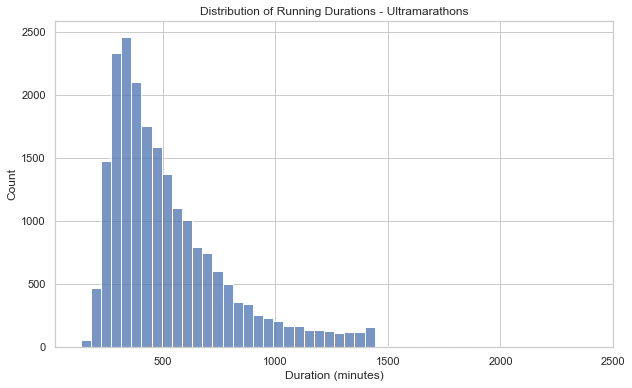

In [16]:
sns.histplot(great_distance_greater_than_zero['distance_mi'], bins=200)
plt.title('Distribution of Running Distances - Ultramarathons')
# plt.xlim(50, 100) # very few entries larger than 100 km, will address those seperatly next
plt.xlabel('Distance (mi)')
plt.show()

sns.histplot(great_distance_greater_than_zero['duration'], bins=50)
plt.title('Distribution of Running Durations - Ultramarathons')
# plt.xlim(200, 300) # very few entries larger than 100 minutes, will address those seperatly next
plt.xlabel('Duration (minutes)')
plt.show()

The primary race distances for ultramarathons include: 30 mile-, 50 mile-, and 100 mile-races, which is reflected in the first graph where there are peaks corresponding to these race distances. Predictable, the overall duration of these races take significantly more time to complete (500 minutes is about 8.3 hours).

Exploring any $\textbf{gender differences}$ in average running distance or duration:

In [17]:
mask = (data['distance_mi']>0.0) & (data['duration']>0.0) # only want to consider distances greater than zero, 
                                                       #  and durations greater than zero - otherwise including
                                                       #  0.0 distances and 0.0 durations will skew results low
summary = data[mask] # apply the mask
gender_summary = summary.groupby('gender')[['distance_mi', 'duration']].mean().reset_index()# group on this new subset

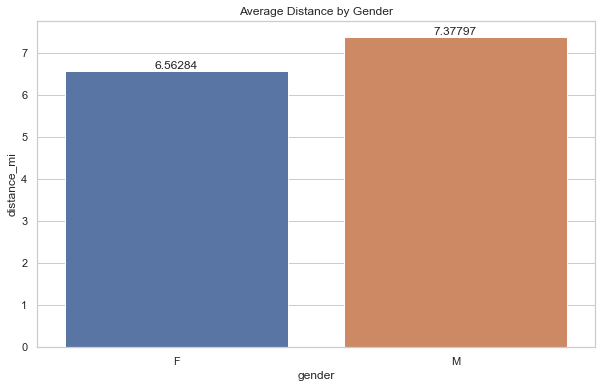

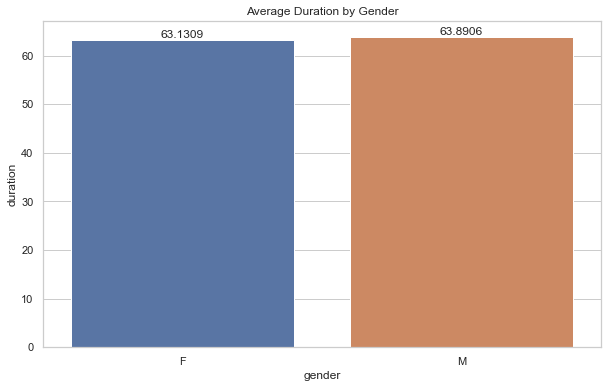

In [18]:
ax = sns.barplot(data=gender_summary, x='gender', y='distance_mi')
plt.title('Average Distance by Gender')
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

ax1 = sns.barplot(data=gender_summary, x='gender', y='duration')
plt.title('Average Duration by Gender')
for i in ax1.containers:
    ax1.bar_label(i,)
plt.show()

There is a small difference in the average distance, however the average duration is about the same for both genders.

## The Impact of COVID-19

This section investigates how the COVID-19 pandemic and corresponding government restrictions affected running activity worldwide. First the athlete training data is merged with country-specific COVID-19 stringency index values to enable joint analysis. Then, the correlation between average running distance and government stringency is calculated. After, running distances before and during periods of high stringency is compared. Additionally, each country’s average running distance before and after the onset of the pandemic (March 2020) is compared and visualized, so that we can see which countries experienced the largest decreases or increases. Finally, the overall change in training volume across all athletes before and after March 2020 is measured.

In [19]:
# Merge data with stringency index
data_with_stringency = pd.merge(data, stringency, how='left', left_on=['country', 'datetime'], right_on=['country', 'date'])

Correlation between $\textbf{stringency and running activity}$:

Correlation between average running distance and average stringency index: 0.04


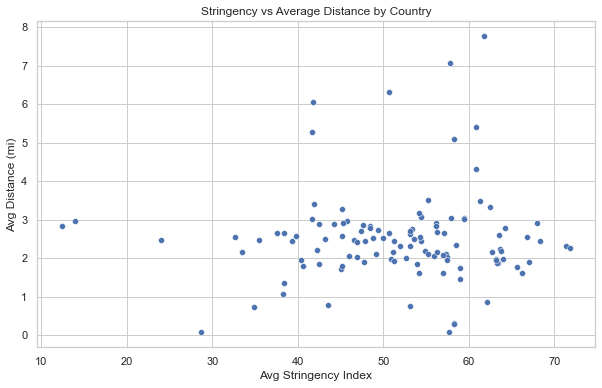

In [20]:
country_stringency_activity = data_with_stringency.groupby('country')[['distance_mi', 'stringency_index']].mean().dropna()
# dropping any rows that contain NULL values

correlation = country_stringency_activity['distance_mi'].corr(country_stringency_activity['stringency_index'])
print("Correlation between average running distance and average stringency index:", np.round(correlation,2))

sns.scatterplot(data=country_stringency_activity, x='stringency_index', y='distance_mi')
plt.title('Stringency vs Average Distance by Country')
plt.xlabel('Avg Stringency Index')
plt.ylabel('Avg Distance (mi)')
plt.show()

The correlation between average running distance and government stringency is a near-zero relationship, suggesting that, at a global level, stricter lockdown measures were not consistently associated with significant reductions or increases in average running activity. While individual countries or athletes may have been strongly impacted by government restrictions, there was no uniform pattern across the dataset as a whole. The scatter plot further supports this observation, showing a wide spread of data points without a clear linear trend.

Change in $\textbf{training behavior}$ during lockdown compared to pre-lockdown:

In [21]:
# Assuming stringency index > 60 is considered "lockdown" 
pre_lockdown = data_with_stringency[data_with_stringency['stringency_index'] < 60]
lockdown = data_with_stringency[data_with_stringency['stringency_index'] >= 60]

pre_avg = pre_lockdown['distance_mi'].mean()
lockdown_avg = lockdown['distance_mi'].mean()
print("Average distance pre-lockdown: ", np.round(pre_avg,2), " miles")
print("Average distance during lockdown: ", np.round(lockdown_avg,2), " miles")

Average distance pre-lockdown:  2.43  miles
Average distance during lockdown:  2.4  miles


By comparing running distances before and during periods of high government stringency, we observed that the average distance remained relatively stable, decreasing only slightly from 2.43 miles pre-lockdown to 2.40 miles during lockdown. This suggests that, while there may have been some localized disruptions, overall running activity distances were largely resilient to the effects of strict COVID-19 restrictions.

Observing $\textbf{change in activity by country}$ in early 2020:

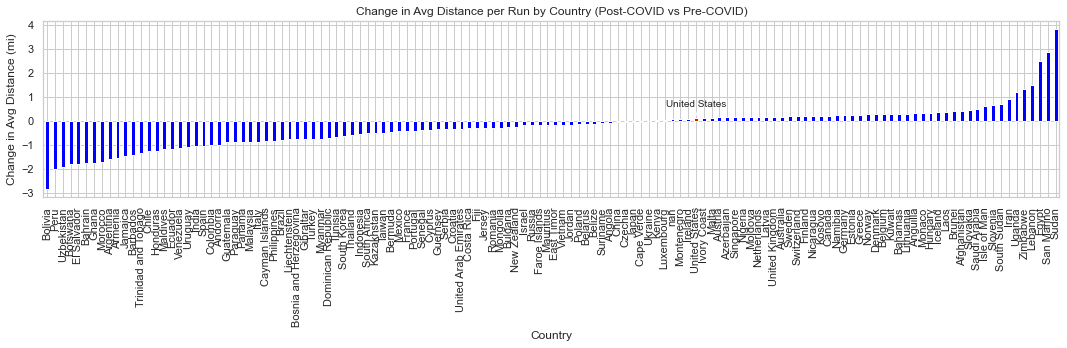

In [22]:
# apply filter to the data to sort out pre-COVID (before March 2020) and post-COVID (after March 2020)
pre_covid = data_with_stringency[(data_with_stringency['datetime'] < '2020-03-01')]
post_covid = data_with_stringency[(data_with_stringency['datetime'] >= '2020-03-01') & (data_with_stringency['datetime'] < '2020-06-01')]

pre_covid_country = pre_covid.groupby('country')['distance_mi'].mean()
post_covid_country = post_covid.groupby('country')['distance_mi'].mean()

change = (post_covid_country - pre_covid_country).dropna().sort_values()

highlight_country = "United States" # country of interest

# Color list to highlight the selected country, blue for others
colors = ['red' if country == highlight_country else 'blue' for country in change.index]

# Plot results
change.plot(kind='bar', figsize=(16,5), color=colors)
ax = change.plot(kind='bar', figsize=(15,5), color=colors)
plt.title('Change in Avg Distance per Run by Country (Post-COVID vs Pre-COVID)')
plt.ylabel('Change in Avg Distance (mi)')
plt.xlabel('Country')
plt.xticks(rotation=90)

# Annotate the highlighted country
if highlight_country in change.index:
    y = change.loc[highlight_country]
    x = list(change.index).index(highlight_country)
    ax.annotate(highlight_country, xy=(x, y), xytext=(x, y+0.5),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                ha='center', fontsize=10)

plt.tight_layout()
plt.show()


This bar chart shows the change in the average running distance per run for each country, comparing post-COVID to pre-COVID periods. Countries are sorted based on the magnitude of change, with negative values indicating a decrease in average running distance after the onset of the pandemic, and positive values indicating an increase. While many countries experienced a small to moderate decline in running distances, a notable number showed resilience or even improvement during the pandemic period. The United States is highlighted in red and annotated for emphasis, showing a relatively small change compared to the global distribution. This visualization highlights the varying impacts of the COVID-19 pandemic on running habits around the world, with some countries adapting differently to restrictions and lockdowns.

Investigating $\textbf{peak training for the Boston Marathon}$ in 2019$^{4}$ vs 2020$^{5}$:

In [23]:
# Filter based on athletes with major marathons and their distance in the months leading up to their major race
major_athletes_mask = (data['major'].notnull()) & (data['distance_mi']>0.0) & (data['duration']>0.0) 
# only want to consider distances greater than zero, 
                                                       #  and durations greater than zero - otherwise including
                                                       #  0.0 distances and 0.0 durations will skew results low
major_athletes = data[major_athletes_mask] # apply the mask


In [24]:
# Sorting based on if the athletes based on Boston 2019 vs Botson 2020
mask_Boston2019 = major_athletes['major'].str.contains("BOSTON 2019")
mask_Boston2020 = major_athletes['major'].str.contains("BOSTON 2020")
major_athletes_2019 = major_athletes[mask_Boston2019]
major_athletes_2020 = major_athletes[mask_Boston2020]

In [25]:
# Assuming training peaks 3 weeks before a marathon
major_event_date_2019 = datetime(2019, 4, 15)
major_event_date_2020 = datetime(2020, 9, 14)
peak_start_2019 = major_event_date_2019 - timedelta(weeks=3)
peak_end_2019 = major_event_date_2019 - timedelta(days=1)
peak_start_2020 = major_event_date_2020 - timedelta(weeks=3)
peak_end_2020 = major_event_date_2020 - timedelta(days=1)

# Peak training is three weeks before the marathon
peak_training_period_2019 = major_athletes_2019[(major_athletes_2019['datetime'] >= peak_start_2019) & (major_athletes_2019['datetime'] <= peak_end_2019)]
peak_training_period_2020 = major_athletes_2020[(major_athletes_2020['datetime'] >= peak_start_2020) & (major_athletes_2020['datetime'] <= peak_end_2020)]

# Training before peak (earlier than peak_start)
pre_peak_training_2019 = major_athletes_2019[(major_athletes_2019['datetime'] < peak_start_2019)]
pre_peak_training_2020 = major_athletes_2020[(major_athletes_2020['datetime'] < peak_start_2020)]

avg_pre_training_2019 = pre_peak_training_2019.groupby('athlete')['distance_mi'].mean().mean()
avg_peak_training_2019 = peak_training_period_2019.groupby('athlete')['distance_mi'].mean().mean()

avg_pre_training_2020 = pre_peak_training_2020.groupby('athlete')['distance_mi'].mean().mean()
avg_peak_training_2020 = peak_training_period_2020.groupby('athlete')['distance_mi'].mean().mean()

print("Average training distance 2019 - before peak marathon preparation (before", peak_start_2019.date(),"): ", np.round(avg_pre_training_2019,2), " miles")
print("Average training distance 2019 - during peak marathon preparation (", peak_start_2019.date(), " to ", peak_end_2019.date(), "):", np.round(avg_peak_training_2019,2), "miles")
print("---")
print("Average training distance 2020 - before peak marathon preparation (before", peak_start_2020.date(),"): ", np.round(avg_pre_training_2020,2), " miles")
print("Average training distance 2020 - during peak marathon preparation (", peak_start_2020.date(), " to ", peak_end_2020.date(), "):", np.round(avg_peak_training_2020,2), "miles")


Average training distance 2019 - before peak marathon preparation (before 2019-03-25 ):  8.84  miles
Average training distance 2019 - during peak marathon preparation ( 2019-03-25  to  2019-04-14 ): 7.27 miles
---
Average training distance 2020 - before peak marathon preparation (before 2020-08-24 ):  7.86  miles
Average training distance 2020 - during peak marathon preparation ( 2020-08-24  to  2020-09-13 ): 7.51 miles


An analysis of training patterns leading up to the Boston Marathon reveals important differences between 2019 and 2020. In 2019, the average training distance before the peak preparation period (before March 25) was 8.84 miles, which decreased slightly to 7.27 miles during the peak training window from March 25 to April 14. This reduction is consistent with a traditional marathon training taper, where runners intentionally lower their mileage in the final weeks to allow for recovery and peak performance on race day.

In 2020, the pattern was notably different. Before the peak training period (before August 24), the average training distance was 7.86 miles, decreasing slightly to 7.51 miles during the peak window from August 24 to September 13. While the drop was less pronounced than in 2019, overall training distances were lower compared to the previous year. This likely reflects the impact of the COVID-19 pandemic, with race postponements, cancellations, and uncertainty affecting athletes' motivation and ability to follow structured training plans. Nonetheless, runners who continued to prepare showed relatively stable mileage even amidst the disruptions.

## Summary of Results and Future Work

Across 2019–2020, average running distance and duration showed a slight gradual decrease. While the 2019 patterns were typical, with clear seasonal oscillations peaking in spring and fall, likely linked to race calendars and training cycles, the COVID-19 pandemic caused pronounced drops and disruptions in 2020, reflecting widespread race cancellations and restrictions.

The correlation between average running distance and government lockdown stringency was near zero, indicating no consistent global trend. A comparison of pre- and during-lockdown periods showed only a minor decrease (2.43 to 2.40 miles), suggesting running activity remained relatively resilient. Country-level analysis highlighted variations, with some countries maintaining or increasing running distances post-pandemic onset.
Examining Boston Marathon preparation revealed that in 2019, runners tapered slightly before race day (8.84 to 7.27 miles), while in 2020, training distances were lower overall (7.86 to 7.51 miles), reflecting the disruptions caused by the pandemic and the shift to a virtual race format.

This analysis provided valuable insights into how running behaviors evolved across 2019 and 2020, highlighting both seasonal training patterns and the disruptions caused by the COVID-19 pandemic. While the overall trends showed resilience in athlete activity, the gradual decline in distance and duration, as well as differences in Boston Marathon preparation between 2019 and 2020, illustrate the pandemic's widespread impact on training routines. However, several questions remain open for further investigation. How did training behavior vary by age group or gender during the pandemic? Were elite athletes affected differently than recreational runners? Additionally, while overall distance patterns were studied, deeper analysis into training frequency, intensity (pace), and motivations behind training shifts could provide a more comprehensive understanding of the pandemic’s effects on athletic behavior. Future work could also explore long-term impacts by extending the dataset into 2021 and beyond, to examine how and when training habits recovered.

---
Sources:

1. Image: https://upload.wikimedia.org/wikipedia/commons/a/a5/Marat%C3%B3n_Medell%C3%ADn_2019.jpg

2. Hale, T., Angrist, N., Goldszmidt, R. $\textit{et al.}$ A global panel database of pandemic policies (Oxford COVID-19 Government Response Tracker). $\textit{Nat Hum Behav}$ $\textbf{5}$, 529–538 (2021). https://doi.org/10.1038/s41562-021-01079-8

3. Max Roser (2021) - “What is the COVID-19 Stringency Index?” Published online at OurWorldinData.org. Retrieved from: 'https://ourworldindata.org/metrics-explained-covid19-stringency-index' [Online Resource].

4. 2019 Boston Marathon: https://en.wikipedia.org/wiki/World_Marathon_Majors

5. 2020 Boston Marathon: https://www.baa.org/124th-boston-marathon-be-held-virtually